# Solar Neighborhood

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Gaia_observes_the_Milky_Way_ESA24305955.jpeg" alt="Drawing" style="width: 400px;"/>

Let's use [Gaia](https://en.wikipedia.org/wiki/Gaia_(spacecraft)) data to look at the properties of stars in the solar neighborhood.

The Gaia Data Release 2 was accompanied by [a paper](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html#T2) that makes loads of observational [Hertzsprung-Russell diagrams](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram), or "color-magnitude" diagrams.  Gaia has been making [stellar parallax](https://en.wikipedia.org/wiki/Parallax) measurments of stars in the Milky Way

![stellar parallax](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/14-104-hubble-parallax.png/520px-14-104-hubble-parallax.png)

Measuments of parallax $\varpi$ in arcseconds observed with a 1 AU baseline can be converted to distances in parsecs as simply $d(\mathrm{pc}) = 1/\varpi(\mathrm{arcsec})$ (it's actually what _defines_ the parsec).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Query the DR3 Archive

We'll be roughly following the [Observational Hertzsprung-Russell diagram](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html#app) paper, including their process for grooming the data to remove astrometric noise, imprecise parallax measurements, etc.  For discussion of the filtering process see [Sec. 2.1](https://www.aanda.org/articles/aa/full_html/2018/08/aa32843-18/aa32843-18.html#S2).

We can do this with a basic query of the [data archive](https://gea.esac.esa.int/archive/), using the GUI to add each condition.  They have also provided the full query in Appendix B, which we'll adopt here with a few changes:

```
SELECT TOP 300000 phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp, parallax FROM gaiadr3.gaia_source

WHERE parallax_over_error > 10

AND parallax > 10

AND phot_g_mean_flux_over_error>50

AND phot_rp_mean_flux_over_error>20

AND phot_bp_mean_flux_over_error>20

AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)

AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)

AND visibility_periods_used>8

AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
```

which we can paste directly into an advanced query window (BTW, to get a description of each field see the [Gaia data model](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html)).

In [2]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


Here we have Gaia observations of a little over $2\times 10^5$ stars in the stellar neighborhood.  For each we have the parallax (reciprocal of the distance, remember), along with some magnitudes that we'll talk about more in a bit.

First let's make a simple histogram of the parallax measurements.

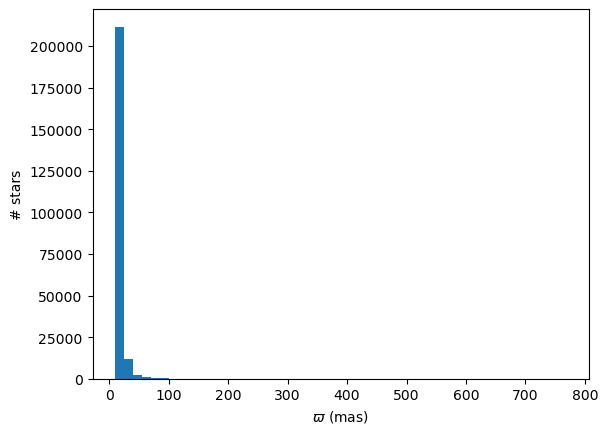

In [3]:
plt.hist(df.parallax, bins=50)
plt.xlabel(r'$\varpi$ (mas)')
plt.ylabel("# stars");

Now distances.

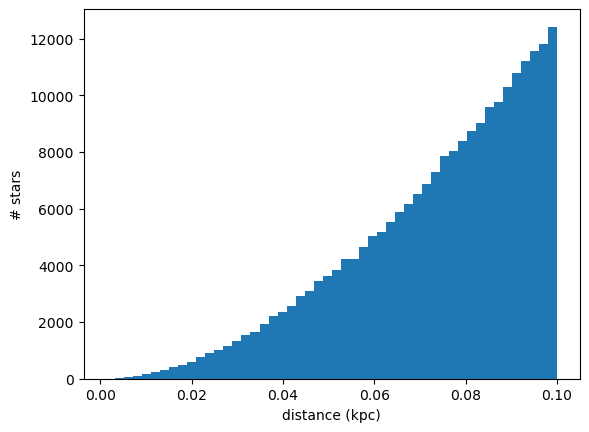

In [4]:
counts, bins, _ = plt.hist(1/df.parallax, bins=50)
plt.xlabel('distance (kpc)')
plt.ylabel("# stars");

That looks mighty power-law-like.  Let's look a little closer.

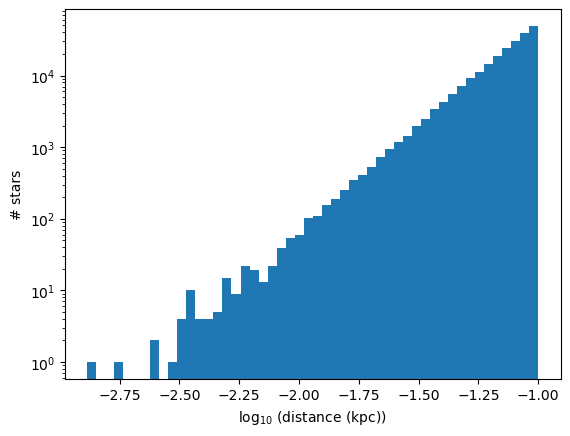

In [5]:
counts_in_log , log_bins, _ = plt.hist(np.log10(1/df.parallax), bins=50, log=True)
plt.xlabel(r'log$_{10}$ (distance (kpc))')
plt.ylabel("# stars");

Our bin heights provide an estimate of the stellar number density as a function of distance from the Sun.  Consider a spherical shell with thickness $dr$ at distance $r$.  If we assume the stellar density $\rho$ is constant, then the number of stars in that spherical shell $dN$ should be:

$$
dN = 4\pi r^2 \rho dr
$$

Each bin of our histogram corresponds to such a spherical shell, so dividing our bin heights (i.e., counts) by the bin width $dr$

$$
dN/dr = 4 \pi r^2 \rho
$$

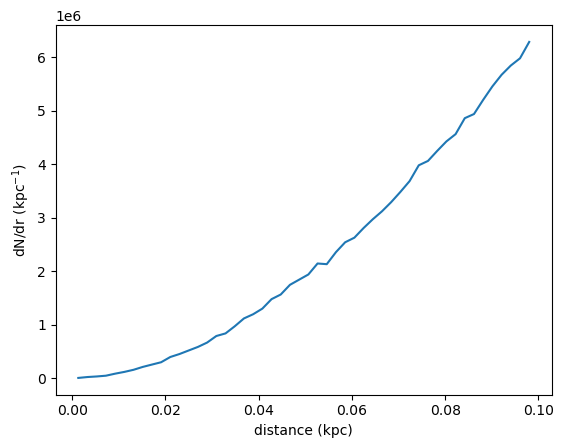

In [6]:
rs = bins[:-1]
dr = np.diff(bins)[0]
dNdr = counts/dr

plt.plot(rs, dNdr)
plt.xlabel('distance (kpc)')
plt.ylabel(r'dN/dr (kpc$^{-1}$)');

If we assume that we have a "complete catalog" out to our maximum distance then we can calculate the average stellar density in the solar neighborhood.

In [7]:
V = 4/3 * np.pi * np.max(1/df.parallax)**3
N = len(df)
ρavg= N/V
print("{} stars per cubic kiloparsec".format(ρavg))

54342556.5788554 stars per cubic kiloparsec


Or, in parsecs...

In [8]:
print("{:.3f} stars per cubic parsec".format(ρavg * (1e3)**-3))

0.054 stars per cubic parsec


Which is consistent with the [accepted value](https://en.wikipedia.org/wiki/Stellar_density) of the local stellar density: 0.059 $M_\odot \mathrm{pc}^{-3}$.

With this estimate of the stellar density in hand, we can compare our constant-density model to the data!

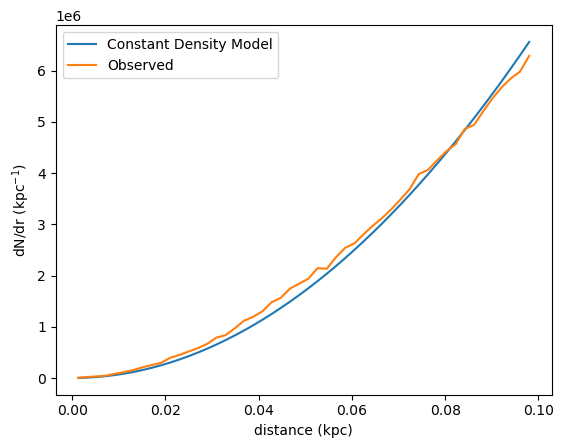

In [9]:
model_dNdr = 4*np.pi*ρavg*rs**2

plt.plot(rs, model_dNdr, label="Constant Density Model")
plt.plot(rs, dNdr, label="Observed")
plt.xlabel('distance (kpc)')
plt.ylabel(r'dN/dr (kpc$^{-1}$)');
plt.legend();

Not bad!  Now, as an excuse to perform our first numerical integration, let's calculate what our model would predict for the total number of stars in the observed volume.

In [10]:
dr = np.diff(rs)[0]
predicted_N = np.sum(model_dNdr)*dr

print("Our model predicts {:.0f} stars, we saw {}".format(predicted_N, N))

Our model predicts 220933 stars, we saw 227629


## HR Diagram

Now let's make our color-magnitude diagram.  For this we need brightness on the y-axis, for which we'll use the total $G$-band magnitude (higher magnitudes are fainter).  On the x-axis we need "color".  We'll be using the diffence in magnitudes when observing with a blue filter ($G_\mathrm{BP}$) and red filter ($G_\mathrm{RP}$).  To give you a sense of what these quantities are, the pass bands for all three filters are shown below.

<img src="https://www.cosmos.esa.int/documents/29201/1645651/GaiaDR2Passbands.png/ba8d3078-0e7a-b316-92d9-cdce748e6484?t=1521129245183" width="500"/>

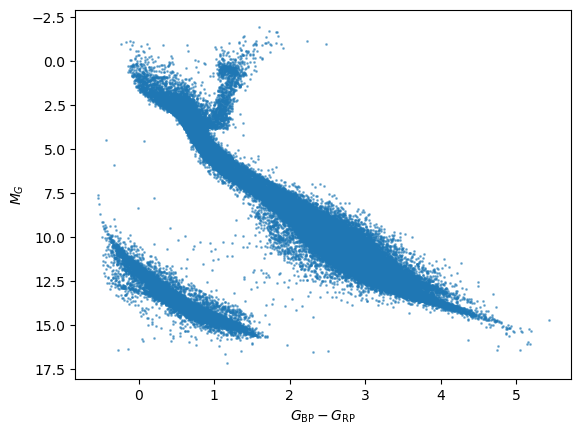

In [11]:
plt.scatter(df.bp_rp, df.mg, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")
# save limits for later use
xlim = plt.xlim()
ylim = plt.ylim()

That's a _lot_ of data.

Compare this to the following diagram to get a sense of what the features correspond to.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/HRDiagram.png/526px-HRDiagram.png" width="500"/>

# Density Plots

It's difficult to see what's going on in the high density regions, so let's work on a density plot.  For this we'll using a Gaussian Kernel Density Estimate (KDE).  Think of this like throughing a little Gaussian distribution down on each data point and adding all of them up to get a smooth estimate of the density of points

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Comparison_of_1D_histogram_and_KDE.png/500px-Comparison_of_1D_histogram_and_KDE.png" width="500"/>

In [12]:
from scipy.stats import gaussian_kde

$2\times 10^5$ is a lot of Gaussians to evaluate, so let's reduce our data set by looking at only the stars within 25 pc ($\varpi > 40$ mas).

In [13]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

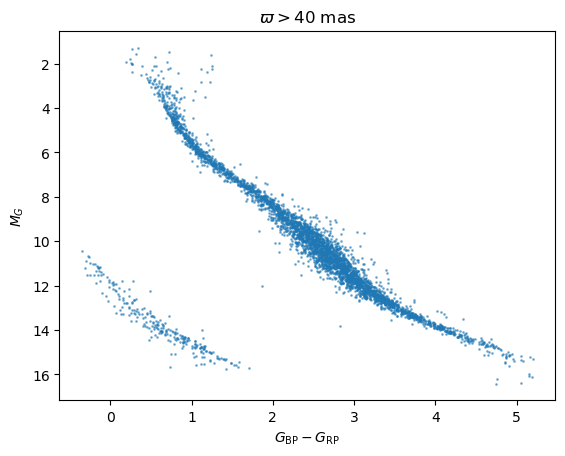

In [14]:
plt.scatter(nearby_df.bp_rp, nearby_df.mg, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.title(r'$\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")
# # save limits for later use
xlim = plt.xlim()
ylim = plt.ylim()

Now let's build our KDE

In [15]:
kde = gaussian_kde(np.vstack([nearby_df.bp_rp, nearby_df.mg]))

and evaluate it on a 2-D grid.

In [16]:
ngrid = 100
x = np.linspace(*xlim, ngrid)
y = np.linspace(*ylim, ngrid)
X, Y = np.meshgrid(x, y)

Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

Finally, let's plot it.

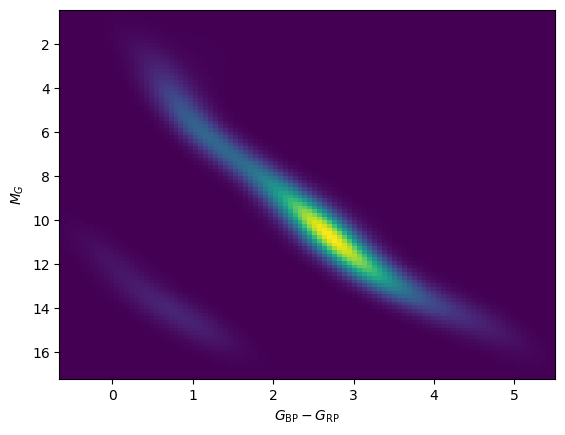

In [17]:
plt.pcolormesh(X, Y, Z, shading='auto')
plt.gca().invert_yaxis()
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$");

We can get creative with visualization techniques, coloring the points of a scatter plot by the density at each point as estimated by a KDE.

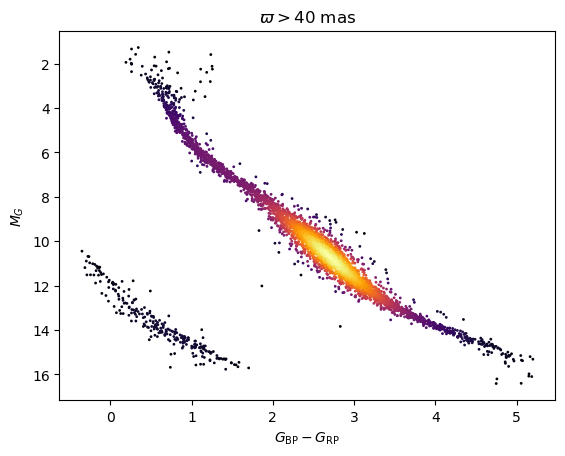

In [18]:
densities = kde(np.vstack([nearby_df.bp_rp, nearby_df.mg]))

plt.scatter(nearby_df.bp_rp, nearby_df.mg, s=1, c=densities, cmap='inferno')
plt.gca().invert_yaxis()
plt.title(r'$\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$");